<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/CNN/CNN_Amazon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 147 (delta 71), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (147/147), 120.19 KiB | 5.46 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Tue Jul 20 20:54:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Amazon'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'CNN'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [10]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 97 kB 3.8 MB/s 
     |████████████████████████████████| 170 kB 20.7 MB/s 
     |████████████████████████████████| 133 kB 57.2 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 62 kB 1.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
!pip install wandb -qq

In [ ]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['selu', 'relu']
        }
    }
}

In [ ]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(Conv1D(filters=128, kernel_size=2, activation=config.activation, input_shape=(window_len, 1)))
    # layer 2
    model.add(Conv1D(filters=64, kernel_size=2, activation=config.activation))
    # layer 3
    model.add(MaxPooling1D(pool_size=2))
    # layer 4
    model.add(Flatten())
    # layer 5
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [ ]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: qbbo0m53
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_CNN/sweeps/qbbo0m53


In [ ]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: muv8e270 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/50
8/8 [==============================] - 30s 104ms/step - loss: 0.1022 - mean_squared_error: 0.1022 - mean_absolute_error: 0.2211 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.0868
Epoch 2/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0370 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.0870
Epoch 3/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0386 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0864
Epoch 4/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0283 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.0899
Epoch 5/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - m

epoch,49
loss,0.00158
mean_squared_error,0.00158
mean_absolute_error,0.02771
val_loss,0.00783
val_mean_squared_error,0.00783
val_mean_absolute_error,0.0655
_runtime,40
_timestamp,1626540919
_step,49
best_val_loss,0.00783


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▂▁▂▂▂▁▂▂▁▁▂▂▂▂▁▂▁▂▂▁▁▂▁▁▁▂▁▁▁▂▂▁
val_loss,▅▅▅▆▄█▃█▄▄▃▃▃▃▃▂▂▄▃▅▃▃▆▂▂▃▂▅▄▂▄▂▃▄▂▂▂▁▃▁
val_mean_squared_error,▅▅▅▆▄█▃█▄▄▃▃▃▃▃▂▂▄▃▅▃▃▆▂▂▃▂▅▄▂▄▂▃▄▂▂▂▁▃▁
val_mean_absolute_error,▃▃▃▄▃█▃▅▃▃▃▅▃▅▄▃▃▅▂▃▂▂▄▂▂▂▂▃▅▂▃▂▂▃▁▂▁▁▂▁
_runtime,▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆▆█████
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆▆█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 0bmhnbsq with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 2s 18ms/step - loss: 0.0765 - mean_squared_error: 0.0765 - mean_absolute_error: 0.1738 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1045
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0311 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.1021
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0294 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.1027
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0283 - val_loss: 0.0143 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.1026
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0014 - mean_squared_erro

epoch,86
loss,0.00021
mean_squared_error,0.00021
mean_absolute_error,0.01011
val_loss,0.00251
val_mean_squared_error,0.00251
val_mean_absolute_error,0.03407
_runtime,23
_timestamp,1626540952
_step,86
best_val_loss,0.00233


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▁▂▁▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▆▄▄▃▄▄▃▂▂▅▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▆▆▄▄▃▄▄▃▂▂▅▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▇▆▆▆▄▄▅▃▃▃▇▃▃▃▃▂▃▃▂▂▂▃▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 3ly2o1p7 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 1s 48ms/step - loss: 0.0946 - mean_squared_error: 0.0946 - mean_absolute_error: 0.2184 - val_loss: 0.0364 - val_mean_squared_error: 0.0364 - val_mean_absolute_error: 0.1677
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0153 - mean_squared_error: 0.0153 - mean_absolute_error: 0.0924 - val_loss: 0.0278 - val_mean_squared_error: 0.0278 - val_mean_absolute_error: 0.1246
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0587 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.1138
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0436 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.0877
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0019 

epoch,99
loss,0.0002
mean_squared_error,0.0002
mean_absolute_error,0.00972
val_loss,0.00258
val_mean_squared_error,0.00258
val_mean_absolute_error,0.03611
_runtime,13
_timestamp,1626540974
_step,99
best_val_loss,0.00249


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 7j0j5e6u with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 1s 48ms/step - loss: 0.2735 - mean_squared_error: 0.2735 - mean_absolute_error: 0.2363 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0745
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0254 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0802
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0391 - val_loss: 0.0453 - val_mean_squared_error: 0.0453 - val_mean_absolute_error: 0.1934
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0187 - mean_squared_error: 0.0187 - mean_absolute_error: 0.1089 - val_loss: 0.0145 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.1066
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0089 - mean_squared_error: 0.0089 

epoch,11
loss,0.00759
mean_squared_error,0.00759
mean_absolute_error,0.06661
val_loss,0.00941
val_mean_squared_error,0.00941
val_mean_absolute_error,0.08333
_runtime,6
_timestamp,1626540992
_step,11
best_val_loss,0.00917


epoch,▁▂▂▃▄▄▅▅▆▇▇█
loss,█▁▁▂▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▂▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▃▄▄▄▃▄▂▄▂▃
val_loss,▁▁▄▁▃▂█▁▂▁▃▁
val_mean_squared_error,▁▁▄▁▃▂█▁▂▁▃▁
val_mean_absolute_error,▁▁▅▂▄▂█▂▃▂▄▁
_runtime,▁▁▁▁▁▁▁▁████
_timestamp,▁▁▁▁▁▁▁▁████
_step,▁▂▂▃▄▄▅▅▆▇▇█


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n6d26vt4 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 1s 15ms/step - loss: 0.0864 - mean_squared_error: 0.0864 - mean_absolute_error: 0.1518 - val_loss: 0.0473 - val_mean_squared_error: 0.0473 - val_mean_absolute_error: 0.1701
Epoch 2/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0504 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0768
Epoch 3/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0591 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0733
Epoch 4/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0493 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0637
Epoch 5/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0030 - mean_squared_erro

epoch,49
loss,0.00086
mean_squared_error,0.00086
mean_absolute_error,0.02086
val_loss,0.00427
val_mean_squared_error,0.00427
val_mean_absolute_error,0.05249
_runtime,14
_timestamp,1626541027
_step,49
best_val_loss,0.00229


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▄▃▃▃▂▂▂▂▂▂▂▂▁▁▂▂▁▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁
val_loss,█▂▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁▂▁▁▂▃▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁▂▁▁▂▃▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▂▃▂▂▂▂▁▂▁▁▁▁▂▃▁▁▃▅▁▁▃▄▁▄▁▁▁▂▁▁▂▁▁▂▁▂
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: pqq9qr0g with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 1s 27ms/step - loss: 0.0902 - mean_squared_error: 0.0902 - mean_absolute_error: 0.2061 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.0994
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0544 - val_loss: 0.0596 - val_mean_squared_error: 0.0596 - val_mean_absolute_error: 0.2172
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0835 - val_loss: 0.0638 - val_mean_squared_error: 0.0638 - val_mean_absolute_error: 0.2256
Epoch 4/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0806 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.1095
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0055 - mean_squared_erro

epoch,14
loss,0.00352
mean_squared_error,0.00352
mean_absolute_error,0.04039
val_loss,0.01705
val_mean_squared_error,0.01705
val_mean_absolute_error,0.11851
_runtime,7
_timestamp,1626541046
_step,14
best_val_loss,0.01545


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▂▃▁▁▂▁▂▂▁▁
val_loss,▁▇█▁▁▃▅▁▃▂▃▂▂▄▁
val_mean_squared_error,▁▇█▁▁▃▅▁▃▂▃▂▂▄▁
val_mean_absolute_error,▁██▂▁▂▅▂▂▁▂▂▂▄▂
_runtime,▁▅▅▅▅▅▅▅▅▅█████
_timestamp,▁▅▅▅▅▅▅▅▅▅█████
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


wandb: Agent Starting Run: pva6plj4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 2s 27ms/step - loss: 0.2028 - mean_squared_error: 0.2028 - mean_absolute_error: 0.3454 - val_loss: 0.0393 - val_mean_squared_error: 0.0393 - val_mean_absolute_error: 0.1726
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0735 - val_loss: 0.0127 - val_mean_squared_error: 0.0127 - val_mean_absolute_error: 0.0879
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0365 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0952
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0278 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0944
Epoch 5/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0013 - mean_squared_erro

epoch,99
loss,0.00044
mean_squared_error,0.00044
mean_absolute_error,0.01543
val_loss,0.00448
val_mean_squared_error,0.00448
val_mean_absolute_error,0.05222
_runtime,19
_timestamp,1626541076
_step,99
best_val_loss,0.00448


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: dacqvwkq with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 2s 16ms/step - loss: 0.0848 - mean_squared_error: 0.0848 - mean_absolute_error: 0.1913 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1017
Epoch 2/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0334 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.0981
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0285 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0981
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0258 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0919
Epoch 5/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0011 - mean_squared_error: 0.

epoch,49
loss,0.00044
mean_squared_error,0.00044
mean_absolute_error,0.01457
val_loss,0.00424
val_mean_squared_error,0.00424
val_mean_absolute_error,0.04857
_runtime,16
_timestamp,1626541109
_step,49
best_val_loss,0.00424


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▄▄▄▅▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▄▁▁▂▂▁▁▁▁▁
val_mean_squared_error,█▆▅▅▄▄▄▅▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▄▁▁▂▂▁▁▁▁▁
val_mean_absolute_error,███▇▆▆▅▆▅▄▃▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▃▂▁▅▁▁▂▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: mupgj8j1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 1s 25ms/step - loss: 0.1249 - mean_squared_error: 0.1249 - mean_absolute_error: 0.2652 - val_loss: 0.0195 - val_mean_squared_error: 0.0195 - val_mean_absolute_error: 0.0945
Epoch 2/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0961 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.1077
Epoch 3/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0469 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.0920
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0306 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.0960
Epoch 5/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0012 - mean_squared_error: 0.

epoch,49
loss,0.0004
mean_squared_error,0.0004
mean_absolute_error,0.01454
val_loss,0.00588
val_mean_squared_error,0.00588
val_mean_absolute_error,0.05483
_runtime,12
_timestamp,1626541141
_step,49
best_val_loss,0.00588


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
val_mean_squared_error,█▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
val_mean_absolute_error,▆█▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
_runtime,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: d1kvy9fp with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 1s 15ms/step - loss: 0.0906 - mean_squared_error: 0.0906 - mean_absolute_error: 0.1311 - val_loss: 0.0267 - val_mean_squared_error: 0.0267 - val_mean_absolute_error: 0.1445
Epoch 2/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0797 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0810
Epoch 3/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0473 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0796
Epoch 4/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0277 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0826
Epoch 5/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0035 - mean_squared_erro

epoch,45
loss,0.00143
mean_squared_error,0.00143
mean_absolute_error,0.02635
val_loss,0.00247
val_mean_squared_error,0.00247
val_mean_absolute_error,0.03787
_runtime,14
_timestamp,1626541166
_step,45
best_val_loss,0.00217


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▃▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▅▃▃▄▃▃▂▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▂▂▁▂▁▁▁▂▁▂▁▁▁▁
val_loss,█▄▃▄▇▂▂▃▂▁▂▁▂▂▃▁▁▂▁▁▁▁▂▁▂▁▁▁▄▁▁▁▁▁▂▃▁▁▂▁
val_mean_squared_error,█▄▃▄▇▂▂▃▂▁▂▁▂▂▃▁▁▂▁▁▁▁▂▁▂▁▁▁▄▁▁▁▁▁▂▃▁▁▂▁
val_mean_absolute_error,█▄▄▄▇▃▂▄▂▂▃▂▃▂▄▁▁▃▂▁▁▁▂▁▂▂▁▁▅▂▁▁▂▁▃▄▂▁▃▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: 0yj63p7u with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 2s 17ms/step - loss: 0.1795 - mean_squared_error: 0.1795 - mean_absolute_error: 0.2338 - val_loss: 0.0579 - val_mean_squared_error: 0.0579 - val_mean_absolute_error: 0.2029
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0299 - mean_squared_error: 0.0299 - mean_absolute_error: 0.1128 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0644
Epoch 3/50
31/31 [==============================] - 0s 7ms/step - loss: 7.7024e-04 - mean_squared_error: 7.7024e-04 - mean_absolute_error: 0.0208 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0555
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0362 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0631
Epoch 5/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0017 - mean_squared_e

epoch,22
loss,0.00045
mean_squared_error,0.00045
mean_absolute_error,0.01558
val_loss,0.00329
val_mean_squared_error,0.00329
val_mean_absolute_error,0.04305
_runtime,12
_timestamp,1626541191
_step,22
best_val_loss,0.00323


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss,▁▁▁▁▁▁▁▁▁▁▁▁▁█▃▁▁▁▁▁▁▁▁
mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁█▃▁▁▁▁▁▁▁▁
mean_absolute_error,▂▂▁▁▁▁▁▁▁▁▁▁▁██▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▂▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆███
_timestamp,▁▁▁▁▁▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆███
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: nbbsh31k with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 2s 49ms/step - loss: 0.0320 - mean_squared_error: 0.0320 - mean_absolute_error: 0.1118 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0782
Epoch 2/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0273 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0810
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0260 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0894
Epoch 4/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0361 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0936
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mea

epoch,49
loss,0.00036
mean_squared_error,0.00036
mean_absolute_error,0.01345
val_loss,0.00408
val_mean_squared_error,0.00408
val_mean_absolute_error,0.04543
_runtime,10
_timestamp,1626541212
_step,49
best_val_loss,0.00408


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▂▂▂▂▂▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▂▁
mean_squared_error,█▁▁▂▂▂▂▂▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▂▁
mean_absolute_error,█▃▃▄▄▄▄▄▃▄▄▂▂▂▂▃▂▁▁▁▂▃▃▃▂▂▃▂▂▁▁▃▂▁▁▁▁▃▄▁
val_loss,▆▅▆▆▄▅▄▃▃█▃▃▃▂▂▅▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▄▁▁▁▁▁▂▁▁
val_mean_squared_error,▆▅▆▆▄▅▄▃▃█▃▃▃▂▂▅▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▄▁▁▁▁▁▂▁▁
val_mean_absolute_error,▅▅▆▇▅▆▅▄▄█▃▃▃▃▃▆▃▂▂▂▂▃▃▂▂▃▂▂▂▁▂▅▂▁▁▁▁▃▂▁
_runtime,▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆████
_timestamp,▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: rhre8hqv with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 2s 16ms/step - loss: 0.0322 - mean_squared_error: 0.0322 - mean_absolute_error: 0.1007 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0906
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0263 - val_loss: 0.0439 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1657
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0636 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0883
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0293 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0953
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0029 - mean_squared_erro

epoch,63
loss,0.00082
mean_squared_error,0.00082
mean_absolute_error,0.01919
val_loss,0.00509
val_mean_squared_error,0.00509
val_mean_absolute_error,0.05132
_runtime,20
_timestamp,1626541244
_step,63
best_val_loss,0.0048


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▄▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▄▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▄▄▂▂▃▂▃▂▂▂▂▂▂▁▂▂▁▂▁▂▂▂▁▂▁▂▂▁▂▁▁▁▂▁▁▂▂
val_loss,▃█▂▃▂▂▄▂▂▂▂▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,▃█▂▃▂▂▄▂▂▂▂▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,▃█▄▃▃▂▄▂▂▂▃▂▂▂▄▂▂▁▁▁▂▁▁▂▁▁▂▁▃▁▁▃▁▁▁▁▁▁▂▁
_runtime,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: p6e6ekpt with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 2s 27ms/step - loss: 0.0630 - mean_squared_error: 0.0630 - mean_absolute_error: 0.1581 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - val_mean_absolute_error: 0.1201
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0553 - val_loss: 0.0431 - val_mean_squared_error: 0.0431 - val_mean_absolute_error: 0.1568
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0789 - val_loss: 0.0220 - val_mean_squared_error: 0.0220 - val_mean_absolute_error: 0.1041
Epoch 4/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0518 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.0953
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.

epoch,34
loss,0.00092
mean_squared_error,0.00092
mean_absolute_error,0.02251
val_loss,0.00893
val_mean_squared_error,0.00893
val_mean_absolute_error,0.0689
_runtime,11
_timestamp,1626541266
_step,34
best_val_loss,0.00701


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▂▃▃▁▃▁▁▂▂▂▁▁▂▂▁▁▁▂▁▁▂▂▁▁▁▁▂▁▁▂▁▁▁▁
mean_squared_error,█▂▃▃▁▃▁▁▂▂▂▁▁▂▂▁▁▁▂▁▁▂▂▁▁▁▁▂▁▁▂▁▁▁▁
mean_absolute_error,█▄▅▅▂▆▂▂▅▃▃▃▂▅▃▂▂▂▃▂▁▄▃▂▂▁▁▃▂▂▃▂▁▁▂
val_loss,▅█▄▃▂▂▂▂▂▂▄▂▂▂▂▁▁▁▁▂▁▂▁▁▁▁▂▂▂▂▃▁▁▁▁
val_mean_squared_error,▅█▄▃▂▂▂▂▂▂▄▂▂▂▂▁▁▁▁▂▁▂▁▁▁▁▂▂▂▂▃▁▁▁▁
val_mean_absolute_error,▅█▄▃▄▃▃▃▃▂▄▂▄▃▂▂▂▂▂▂▂▄▁▁▁▁▂▃▂▂▅▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: c2yqf7s2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
31/31 [==============================] - 2s 16ms/step - loss: 0.0709 - mean_squared_error: 0.0709 - mean_absolute_error: 0.1396 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.1129
Epoch 2/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0574 - val_loss: 0.0418 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1827
Epoch 3/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0488 - val_loss: 0.0146 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.1078
Epoch 4/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0471 - val_loss: 0.0314 - val_mean_squared_error: 0.0314 - val_mean_absolute_error: 0.1364
Epoch 5/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0085 - mean_squared_erro

epoch,36
loss,0.00049
mean_squared_error,0.00049
mean_absolute_error,0.01636
val_loss,0.00679
val_mean_squared_error,0.00679
val_mean_absolute_error,0.05952
_runtime,15
_timestamp,1626541293
_step,36
best_val_loss,0.00556


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▁▂▁▁▂▁▁▁▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▁▂▁▁▂▁▁▁▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▄▄▃▃▄▂▂▃▂▂▂▄▁▂▁▃▂▁▂▃▁▁▁▂▁▁▂▁▂▂▁▂▁
val_loss,▃█▃▆▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▃▁▁
val_mean_squared_error,▃█▃▆▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▃▁▁
val_mean_absolute_error,▄█▄▅▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▂▁▁▂▁▁▁▁▂▁▁▁▂▂▂▄▁▁
_runtime,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: aw8pvmt6 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 1s 53ms/step - loss: 4.9248 - mean_squared_error: 4.9248 - mean_absolute_error: 1.3337 - val_loss: 0.0184 - val_mean_squared_error: 0.0184 - val_mean_absolute_error: 0.1066
Epoch 2/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0571 - val_loss: 0.0166 - val_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.1013
Epoch 3/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0352 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.0986
Epoch 4/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0337 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.0970
Epoch 5/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0088 - mean_squared_error: 0.0088 

epoch,38
loss,0.00174
mean_squared_error,0.00174
mean_absolute_error,0.03316
val_loss,0.02264
val_mean_squared_error,0.02264
val_mean_absolute_error,0.11416
_runtime,9
_timestamp,1626541314
_step,38
best_val_loss,0.00709


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▂▂▁▁▂▂▂▁▂▄▁▁▂▂▂▃▁▁▁▂▂▁▁▁▁▁▄▁▁▁▁▁▃▂▁
val_loss,▁▁▁▁▅▁▁▁▃▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▁▁▁▅▁▁▁▃▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▁▁▁▁▆▁▁▂▄▂▁▁▅▁▁▂▁▁▁▁▁▁▂▂▁▁▂▁▁█▁▁▁▁▁▂▁▁▁
_runtime,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆▆▆▆████
_timestamp,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆▆▆▆████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 7vmhgv2k with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 1s 27ms/step - loss: 0.0860 - mean_squared_error: 0.0860 - mean_absolute_error: 0.1506 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0955
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0413 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.1113
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0402 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0945
Epoch 4/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0334 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0821
Epoch 5/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0044 - mean_squared_erro

epoch,55
loss,0.00054
mean_squared_error,0.00054
mean_absolute_error,0.01787
val_loss,0.00248
val_mean_squared_error,0.00248
val_mean_absolute_error,0.03767
_runtime,13
_timestamp,1626541339
_step,55
best_val_loss,0.0024


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▂▂▂▁▂▁▁▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁
val_loss,▅▆▅▅▄█▃▄▃▂▃▂▂▂▂▂▄▁▁▂▃▁▁▂▂▁▁▁▁▁▂▁▁▁▂▂▂▂▁▁
val_mean_squared_error,▅▆▅▅▄█▃▄▃▂▃▂▂▂▂▂▄▁▁▂▃▁▁▂▂▁▁▁▁▁▂▁▁▁▂▂▂▂▁▁
val_mean_absolute_error,▆█▆▅▆█▅▄▃▄▅▃▃▂▃▂▅▂▂▂▅▂▂▄▃▁▁▂▁▁▃▂▁▂▄▃▄▂▂▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: xxa3effp with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 1s 28ms/step - loss: 0.0609 - mean_squared_error: 0.0609 - mean_absolute_error: 0.1664 - val_loss: 0.0196 - val_mean_squared_error: 0.0196 - val_mean_absolute_error: 0.1277
Epoch 2/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0451 - val_loss: 0.0166 - val_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.0998
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0264 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.0990
Epoch 4/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0259 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.0964
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0011 - mean_squared_erro

epoch,121
loss,0.00023
mean_squared_error,0.00023
mean_absolute_error,0.01077
val_loss,0.00247
val_mean_squared_error,0.00247
val_mean_absolute_error,0.03536
_runtime,21
_timestamp,1626541373
_step,121
best_val_loss,0.00246


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: rlcj28ot with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 1s 53ms/step - loss: 0.1885 - mean_squared_error: 0.1885 - mean_absolute_error: 0.2976 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - val_mean_absolute_error: 0.1304
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0401 - val_loss: 0.0218 - val_mean_squared_error: 0.0218 - val_mean_absolute_error: 0.1182
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0596 - val_loss: 0.0968 - val_mean_squared_error: 0.0968 - val_mean_absolute_error: 0.2622
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0289 - mean_squared_error: 0.0289 - mean_absolute_error: 0.1286 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.1040
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0039 - mean_squared_error: 0.0039

epoch,78
loss,0.00039
mean_squared_error,0.00039
mean_absolute_error,0.01568
val_loss,0.00326
val_mean_squared_error,0.00326
val_mean_absolute_error,0.04685
_runtime,12
_timestamp,1626541403
_step,78
best_val_loss,0.00251


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▄▃▂▂▃▂▂▃▂▂▁▂▂▂▂▁▁▂▁▂▂▂▁▂▁▂▂▁▁▂▁▁▂▂▁▂▁
val_loss,▃█▆▂▃▂▁▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▃█▆▂▃▂▁▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▄█▇▃▃▃▂▂▂▂▂▂▃▁▁▁▁▂▂▁▁▁▂▁▄▁▁▂▁▂▁▁▂▁▁▁▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██████
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: fj70obzq with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 2s 53ms/step - loss: 0.0894 - mean_squared_error: 0.0894 - mean_absolute_error: 0.2016 - val_loss: 0.0282 - val_mean_squared_error: 0.0282 - val_mean_absolute_error: 0.1197
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0478 - val_loss: 0.0188 - val_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.0966
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0549 - val_loss: 0.0195 - val_mean_squared_error: 0.0195 - val_mean_absolute_error: 0.0985
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0454 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - val_mean_absolute_error: 0.1077
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mea

epoch,49
loss,0.00092
mean_squared_error,0.00092
mean_absolute_error,0.02306
val_loss,0.00723
val_mean_squared_error,0.00723
val_mean_absolute_error,0.06782
_runtime,11
_timestamp,1626541428
_step,49
best_val_loss,0.00723


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▂▂▂▁▂▂▁▁▂▁▁▁▁▃▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▂▂▁▂▂▁▁▂▁▁▁▁▃▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▄▃▄▂▄▃▁▂▄▂▁▁▁▅▃▂▁▁▁▂▂▃▂▂▁▁▂▁▂▂▁▂▂▂▂▂▁▁
val_loss,█▅▅▆▄▅▇▃▂▅▂▂▂▂▅▃▃▃▂▂▂▃▄▅▂▂▂▂▃▂▂▃▂▂▂▃▂▂▁▁
val_mean_squared_error,█▅▅▆▄▅▇▃▂▅▂▂▂▂▅▃▃▃▂▂▂▃▄▅▂▂▂▂▃▂▂▃▂▂▂▃▂▂▁▁
val_mean_absolute_error,▇▅▅▆▄▅▇▃▄█▄▃▂▂▅▃▃▃▂▂▃▆▇█▂▃▂▂▃▂▂▃▂▂▂▃▂▁▁▁
_runtime,▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆██████
_timestamp,▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆██████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: vcldw0d9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 1s 52ms/step - loss: 0.1458 - mean_squared_error: 0.1458 - mean_absolute_error: 0.2903 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.1064
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0864 - val_loss: 0.0295 - val_mean_squared_error: 0.0295 - val_mean_absolute_error: 0.1275
Epoch 3/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0723 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.1205
Epoch 4/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0583 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0876
Epoch 5/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0015 - mean_squared_error: 0.0015

epoch,98
loss,0.00043
mean_squared_error,0.00043
mean_absolute_error,0.01441
val_loss,0.00638
val_mean_squared_error,0.00638
val_mean_absolute_error,0.05813
_runtime,15
_timestamp,1626541458
_step,98
best_val_loss,0.00635


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆█▅▅▅▅▄▄▄▄▄▄▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▆█▅▅▅▅▄▄▄▄▄▄▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆█▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: llq4put1 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 1s 27ms/step - loss: 0.1139 - mean_squared_error: 0.1139 - mean_absolute_error: 0.1749 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0980
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0470 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0902
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0542 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0947
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0452 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0863
Epoch 5/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0041 - mean_squared_erro

epoch,53
loss,0.0008
mean_squared_error,0.0008
mean_absolute_error,0.02065
val_loss,0.00368
val_mean_squared_error,0.00368
val_mean_absolute_error,0.04353
_runtime,14
_timestamp,1626541490
_step,53
best_val_loss,0.00232


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▅▄▃▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▂▂▁▁▁▁▂▂
val_loss,▆▇▆▅▅█▄▄█▃▃▂▂▂▂▂▂▂▃▃▁▁▁▁▁▁▂▂▁▁▁▁▁▁▃▂▂▁▁▂
val_mean_squared_error,▆▇▆▅▅█▄▄█▃▃▂▂▂▂▂▂▂▃▃▁▁▁▁▁▁▂▂▁▁▁▁▁▁▃▂▂▁▁▂
val_mean_absolute_error,▆▆▆▅▅▆▅▄█▃▃▃▂▂▂▂▂▂▃▄▂▂▁▂▁▁▂▂▁▁▁▁▁▁▃▃▃▁▁▂
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: fhy69oc7 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 1s 16ms/step - loss: 0.0264 - mean_squared_error: 0.0264 - mean_absolute_error: 0.0840 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0838
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0601 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0752
Epoch 3/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0356 - val_loss: 0.0140 - val_mean_squared_error: 0.0140 - val_mean_absolute_error: 0.0870
Epoch 4/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0366 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0733
Epoch 5/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0014 - mean_squared_error: 0.

epoch,49
loss,0.00036
mean_squared_error,0.00036
mean_absolute_error,0.01326
val_loss,0.00259
val_mean_squared_error,0.00259
val_mean_absolute_error,0.04112
_runtime,17
_timestamp,1626541520
_step,49
best_val_loss,0.00225


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▄▃▃▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▇▄▃▃▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,▇█▆▆▄▃▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁
val_loss,▆▅█▄▇▆▅▂▄▂▂▂▁▁▂▂▁▁▂▁▁▃▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▆▅█▄▇▆▅▂▄▂▂▂▁▁▂▂▁▁▂▁▁▃▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆█▆█▇▅▃▅▂▃▂▂▂▂▂▂▁▄▁▁▅▃▄▁▂▁▂▂▁▂▁▁▁▁▂▁▁▁▂
_runtime,▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: nzuqlxvz with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 2s 29ms/step - loss: 0.0236 - mean_squared_error: 0.0236 - mean_absolute_error: 0.1007 - val_loss: 0.0537 - val_mean_squared_error: 0.0537 - val_mean_absolute_error: 0.1946
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0156 - mean_squared_error: 0.0156 - mean_absolute_error: 0.0923 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0727
Epoch 3/200
16/16 [==============================] - 0s 10ms/step - loss: 9.5107e-04 - mean_squared_error: 9.5107e-04 - mean_absolute_error: 0.0221 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0684
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0532 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0733
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0012 - mean_squ

epoch,107
loss,0.0002
mean_squared_error,0.0002
mean_absolute_error,0.00981
val_loss,0.00201
val_mean_squared_error,0.00201
val_mean_absolute_error,0.03157
_runtime,23
_timestamp,1626541556
_step,107
best_val_loss,0.00197


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▃▅▃▂▂▂▂▂▁▂▁▁▂▂▁▂▁▁▁▂▁▁▁▂▂▂▂▁▁▁▂▁▂▁▁▁▁
val_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: msc6rc8q with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 2s 17ms/step - loss: 0.0735 - mean_squared_error: 0.0735 - mean_absolute_error: 0.1927 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.0976
Epoch 2/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0271 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.0961
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0246 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0939
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0253 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0924
Epoch 5/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0012 - mean_squared_error: 0.

epoch,49
loss,0.00035
mean_squared_error,0.00035
mean_absolute_error,0.01328
val_loss,0.00509
val_mean_squared_error,0.00509
val_mean_absolute_error,0.05034
_runtime,19
_timestamp,1626541589
_step,49
best_val_loss,0.00473


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇██▆▅▅▅▅▅▄▃▃▃▃▃▂▂▂▃▃▂▂▂▂▂▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▇██▆▅▅▅▅▅▄▃▃▃▃▃▂▂▂▃▃▂▂▂▂▂▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▇▇▇▆▆▅▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 79zu07vg with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 1s 27ms/step - loss: 0.2355 - mean_squared_error: 0.2355 - mean_absolute_error: 0.3520 - val_loss: 0.0319 - val_mean_squared_error: 0.0319 - val_mean_absolute_error: 0.1342
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0690 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0769
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0315 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0766
Epoch 4/100
16/16 [==============================] - 0s 6ms/step - loss: 8.0326e-04 - mean_squared_error: 8.0326e-04 - mean_absolute_error: 0.0200 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0624
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 4.6936e-04 - mean_

epoch,99
loss,0.00019
mean_squared_error,0.00019
mean_absolute_error,0.00987
val_loss,0.00237
val_mean_squared_error,0.00237
val_mean_absolute_error,0.03446
_runtime,21
_timestamp,1626541642
_step,99
best_val_loss,0.00217


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁
_runtime,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: rckme7xg with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 1s 15ms/step - loss: 0.0300 - mean_squared_error: 0.0300 - mean_absolute_error: 0.0988 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.1002
Epoch 2/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0296 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0871
Epoch 3/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0269 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.0885
Epoch 4/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0299 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.0988
Epoch 5/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0013 - mean_squared_erro

epoch,88
loss,0.00045
mean_squared_error,0.00045
mean_absolute_error,0.01514
val_loss,0.0035
val_mean_squared_error,0.0035
val_mean_absolute_error,0.04602
_runtime,25
_timestamp,1626541681
_step,88
best_val_loss,0.00344


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▅▅▄▃▃▃▄▄▃▂▃▂▂▂▃▂▃▂▂▂▂▃▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁
val_mean_squared_error,▇█▅▅▄▃▃▃▄▄▃▂▃▂▂▂▃▂▃▂▂▂▂▃▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▆▄▄▄▃▄▄▃▃▃▃▃▃▄▂▃▄▂▂▂▃▂▂▂▂▃▂▁▂▁▃▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: mbxrwsw6 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 2s 58ms/step - loss: 0.2228 - mean_squared_error: 0.2228 - mean_absolute_error: 0.3067 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.1043
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0409 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.1088
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0293 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.1081
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0466 - val_loss: 0.0140 - val_mean_squared_error: 0.0140 - val_mean_absolute_error: 0.0928
Epoch 5/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - m

epoch,49
loss,0.00042
mean_squared_error,0.00042
mean_absolute_error,0.01488
val_loss,0.00467
val_mean_squared_error,0.00467
val_mean_absolute_error,0.04799
_runtime,13
_timestamp,1626541708
_step,49
best_val_loss,0.00427


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▃▂▁▁▂▁▂▃▁▁▁▁▁▁▃▁▁▁▁▁▂▁▁▁▂▂▁▁▁▁▁▁▂▁▁▁
val_loss,▅▅▇▄█▃▃▃▂▃▄▃▂▂▂▂▁▃▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁
val_mean_squared_error,▅▅▇▄█▃▃▃▂▃▄▃▂▂▂▂▁▃▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁
val_mean_absolute_error,▇▇▇▅█▅▄▄▃▃▄▃▃▃▂▂▂▅▃▂▂▂▂▂▂▂▂▁▄▁▁▁▁▁▁▁▃▁▁▁
_runtime,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇████
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 1g7o1b17 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 1s 16ms/step - loss: 0.0212 - mean_squared_error: 0.0212 - mean_absolute_error: 0.0827 - val_loss: 0.0144 - val_mean_squared_error: 0.0144 - val_mean_absolute_error: 0.1050
Epoch 2/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0535 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0957
Epoch 3/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0366 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - val_mean_absolute_error: 0.1174
Epoch 4/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0418 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0686
Epoch 5/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0021 - mean_squared_erro

epoch,49
loss,0.00043
mean_squared_error,0.00043
mean_absolute_error,0.01511
val_loss,0.00296
val_mean_squared_error,0.00296
val_mean_absolute_error,0.04562
_runtime,18
_timestamp,1626541744
_step,49
best_val_loss,0.00217


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▆▅▄▃▄▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▄█▃▃▂▂▂▂▂▄▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▅▄█▃▃▂▂▂▂▂▄▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇▆█▄▄▃▂▃▄▃▅▂▂▂▃▂▄▂▁▁▁▁▁▁▁▁▂▁▁▁▃▂▁▁▁▂▁▂▁▂
_runtime,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: sb3z0fpd with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 2s 29ms/step - loss: 0.0599 - mean_squared_error: 0.0599 - mean_absolute_error: 0.1430 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.1115
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0567 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0748
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0379 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0852
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0298 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0868
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0018 - mean_squared_erro

epoch,73
loss,0.0003
mean_squared_error,0.0003
mean_absolute_error,0.01223
val_loss,0.00416
val_mean_squared_error,0.00416
val_mean_absolute_error,0.04503
_runtime,18
_timestamp,1626541788
_step,73
best_val_loss,0.00207


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁
mean_squared_error,▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁
mean_absolute_error,▅▃▂▂▂▂▂▁▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁█▁▁▁
val_loss,▇▃▅▂▂▃▂▂▃▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁█▂▂▂
val_mean_squared_error,▇▃▅▂▂▃▂▂▃▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁█▂▂▂
val_mean_absolute_error,▇▄▅▃▃▄▃▃▄▃▃▃▂▂▂▂▁▁▂▁▁▁▁▁▂▁▁▁▃▁▁▁▁▁▁▁█▃▂▂
_runtime,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ks375i2n with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 1s 16ms/step - loss: 0.0674 - mean_squared_error: 0.0674 - mean_absolute_error: 0.1652 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.1001
Epoch 2/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0300 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.1029
Epoch 3/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0314 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.0920
Epoch 4/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0324 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0879
Epoch 5/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0016 - mean_squared_erro

epoch,81
loss,0.00039
mean_squared_error,0.00039
mean_absolute_error,0.01425
val_loss,0.00471
val_mean_squared_error,0.00471
val_mean_absolute_error,0.04809
_runtime,24
_timestamp,1626541828
_step,81
best_val_loss,0.00396


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▆▅▅▄▃▃▂▃▃▂▂▂▂▂▂▂▂▂▃▁▂▁▁▁▂▁▁▁▂▁▂▁▁▂▁▂▁
val_mean_squared_error,██▇▆▅▅▄▃▃▂▃▃▂▂▂▂▂▂▂▂▂▃▁▂▁▁▁▂▁▁▁▂▁▂▁▁▂▁▂▁
val_mean_absolute_error,█▇▆▅▅▅▄▃▃▃▃▃▂▃▂▂▃▂▂▂▂▃▂▃▂▂▁▂▁▁▂▂▁▂▁▁▂▁▂▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: y42gzyen with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 2s 54ms/step - loss: 0.1257 - mean_squared_error: 0.1257 - mean_absolute_error: 0.2503 - val_loss: 0.0143 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.0846
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0447 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0871
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0288 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0871
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0251 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0876
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0010 - mean_squared_error: 0.0010 

epoch,99
loss,0.00025
mean_squared_error,0.00025
mean_absolute_error,0.01099
val_loss,0.00314
val_mean_squared_error,0.00314
val_mean_absolute_error,0.04176
_runtime,17
_timestamp,1626541864
_step,99
best_val_loss,0.00314


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▃▁▁▁▁▂▁▁▂▁▁▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val_loss,█▇▆▅▅▄▇▃▃▃▅▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁
val_mean_squared_error,█▇▆▅▅▄▇▃▃▃▅▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁
val_mean_absolute_error,██▇▆▅▅▇▄▄▄▆▄▄▃▃▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▃▁▁▂▁▁
_runtime,▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: lznhmn6n with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 2s 17ms/step - loss: 0.0291 - mean_squared_error: 0.0291 - mean_absolute_error: 0.0920 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.0979
Epoch 2/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0362 - val_loss: 0.0115 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0891
Epoch 3/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0277 - val_loss: 0.0213 - val_mean_squared_error: 0.0213 - val_mean_absolute_error: 0.1107
Epoch 4/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0383 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0725
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0010 - mean_squared_error: 0.

epoch,49
loss,0.00024
mean_squared_error,0.00024
mean_absolute_error,0.01117
val_loss,0.00245
val_mean_squared_error,0.00245
val_mean_absolute_error,0.03458
_runtime,21
_timestamp,1626541911
_step,49
best_val_loss,0.00235


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▃▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▃▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▄▅▃▂▄▃▂▂▃▂▂▂▁▂▁▂▁▂▁▁▁▂▁▂▁▁▁▁▁▂▁▁▁▁▂▁▁
val_loss,▅▄▆▃▂▂▂▂▂▂█▂▂▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▅▄▆▃▂▂▂▂▂▂█▂▂▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▅▄▆▃▃▂▂▂▂▂█▂▂▂▂▂▄▂▁▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: rnsilxd2 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 2s 18ms/step - loss: 0.2799 - mean_squared_error: 0.2799 - mean_absolute_error: 0.3020 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0814
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0300 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0646
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 8.6037e-04 - mean_squared_error: 8.6037e-04 - mean_absolute_error: 0.0217 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0609
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 5.5798e-04 - mean_squared_error: 5.5798e-04 - mean_absolute_error: 0.0173 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - val_mean_absolute_error: 0.0563
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 4.9993e-04

epoch,52
loss,0.0002
mean_squared_error,0.0002
mean_absolute_error,0.0104
val_loss,0.00211
val_mean_squared_error,0.00211
val_mean_absolute_error,0.03279
_runtime,20
_timestamp,1626541945
_step,52
best_val_loss,0.00204


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
val_loss,█▄▄▃▃▃▂▃▂▂▂▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▃▃▃▂▃▂▂▂▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▄▄▄▃▄▃▂▂▂▂▂▂▃▂▁▂▂▂▂▁▁▁▁▂▂▁▁▂▂▁▂▁▂▃▁▂▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: xuqwgi2c with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 1s 26ms/step - loss: 4.4215 - mean_squared_error: 4.4215 - mean_absolute_error: 1.0344 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1083
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0338 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.1144
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0244 - mean_squared_error: 0.0244 - mean_absolute_error: 0.0783 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.1026
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0295 - val_loss: 0.0286 - val_mean_squared_error: 0.0286 - val_mean_absolute_error: 0.1242
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0310 - mean_squared_erro

epoch,23
loss,0.0096
mean_squared_error,0.0096
mean_absolute_error,0.06396
val_loss,0.04497
val_mean_squared_error,0.04497
val_mean_absolute_error,0.19642
_runtime,11
_timestamp,1626541972
_step,23
best_val_loss,0.00578


epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
loss,█▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▂▁▃▂▄▂▂▃▂▂▃▁▃▁▁▂▃▁▁▃▁▂
val_loss,▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▃▁▁
val_mean_squared_error,▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▃▁▁
val_mean_absolute_error,▁▁▁▂▃▁▂▂▁▂▂▁▁▁▂▁▁█▁▂▁▅▁▂
_runtime,▁▁▁▁▁▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆████
_timestamp,▁▁▁▁▁▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆████
_step,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██


wandb: Agent Starting Run: 32pb9vgv with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 1s 53ms/step - loss: 0.1151 - mean_squared_error: 0.1151 - mean_absolute_error: 0.1960 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.1117
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0403 - val_loss: 0.0197 - val_mean_squared_error: 0.0197 - val_mean_absolute_error: 0.1271
Epoch 3/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0687 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.1304
Epoch 4/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0510 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - val_mean_absolute_error: 0.1769
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0088 - mean_squared_error: 0.0088

epoch,80
loss,0.00114
mean_squared_error,0.00114
mean_absolute_error,0.02727
val_loss,0.00303
val_mean_squared_error,0.00303
val_mean_absolute_error,0.0447
_runtime,15
_timestamp,1626542002
_step,80
best_val_loss,0.00249


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▆▅▄▄▃▂▃▃▂▂▂▁▁▁▂▁▂▂▂▁▂▂▂▂▁▁▁▂▂▁▂▂▁▁▁▂
val_loss,▇█▆▅▅▄▄▃▃▃▄▄▃▃▂▅▂▃▂▂▁▁▁▂▁▁▁▁▂▁▁▁▂▂▁▁▁▁▂▁
val_mean_squared_error,▇█▆▅▅▄▄▃▃▃▄▄▃▃▂▅▂▃▂▂▁▁▁▂▁▁▁▁▂▁▁▁▂▂▁▁▁▁▂▁
val_mean_absolute_error,▇█▆▆▅▅▄▃▃▃▄▄▃▄▃▆▂▃▂▂▁▁▂▂▁▂▁▁▃▂▁▁▂▂▂▁▂▁▂▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: i9do3rln with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 2s 17ms/step - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.1099 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.1019
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0387 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.1155
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0380 - val_loss: 0.0209 - val_mean_squared_error: 0.0209 - val_mean_absolute_error: 0.1296
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0456 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0889
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0014 - mean_squared_erro

epoch,68
loss,0.00138
mean_squared_error,0.00138
mean_absolute_error,0.02634
val_loss,0.00456
val_mean_squared_error,0.00456
val_mean_absolute_error,0.05093
_runtime,25
_timestamp,1626542047
_step,68
best_val_loss,0.00447


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▅▁▁▂▂▁▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂
mean_squared_error,█▃▂▅▁▁▂▂▁▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂
mean_absolute_error,█▆▅▇▂▂▃▃▃▄▄▃▂▂▂▃▂▃▂▃▂▁▁▂▂▂▂▁▂▂▂▃▁▂▂▁▂▁▁▃
val_loss,▅▅▄▃▃▃▃▂▂▅▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁█▁█▂▁▁
val_mean_squared_error,▅▅▄▃▃▃▃▂▂▅▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁█▁█▂▁▁
val_mean_absolute_error,▅▆▄▄▄▄▄▂▂▅▅▂▂▂▂▃▂▂▃▁▂▂▁▁▂▁▂▁▁▁▁▁▁▁█▁█▂▁▁
_runtime,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 2yw6jzzh with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 1s 27ms/step - loss: 0.1665 - mean_squared_error: 0.1665 - mean_absolute_error: 0.3125 - val_loss: 0.0254 - val_mean_squared_error: 0.0254 - val_mean_absolute_error: 0.1401
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0896 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.0912
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0494 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.1033
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0296 - val_loss: 0.0151 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.0978
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0013 - mean_squared_error: 0.

epoch,49
loss,0.00043
mean_squared_error,0.00043
mean_absolute_error,0.01446
val_loss,0.00602
val_mean_squared_error,0.00602
val_mean_absolute_error,0.05692
_runtime,15
_timestamp,1626542098
_step,49
best_val_loss,0.00602


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▅▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: biqu9e3j with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 1s 31ms/step - loss: 0.0701 - mean_squared_error: 0.0701 - mean_absolute_error: 0.1827 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.1151
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0480 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.1096
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0295 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.0995
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0285 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0998
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0013 - mean_squared_erro

epoch,99
loss,0.00022
mean_squared_error,0.00022
mean_absolute_error,0.01014
val_loss,0.00307
val_mean_squared_error,0.00307
val_mean_absolute_error,0.03888
_runtime,23
_timestamp,1626542139
_step,99
best_val_loss,0.003


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▆▅▅▄▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁
val_mean_squared_error,▇█▆▅▅▄▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 39127b4m with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 1s 27ms/step - loss: 0.0494 - mean_squared_error: 0.0494 - mean_absolute_error: 0.1119 - val_loss: 0.0196 - val_mean_squared_error: 0.0196 - val_mean_absolute_error: 0.1241
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0694 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0804
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0434 - val_loss: 0.0184 - val_mean_squared_error: 0.0184 - val_mean_absolute_error: 0.0983
Epoch 4/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0530 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0948
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0045 - mean_squared_error: 0.

epoch,49
loss,0.00074
mean_squared_error,0.00074
mean_absolute_error,0.02052
val_loss,0.00285
val_mean_squared_error,0.00285
val_mean_absolute_error,0.03746
_runtime,15
_timestamp,1626542171
_step,49
best_val_loss,0.00256


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,██▆▆▆▅▅▄▅▃▃▃▃▃▃▃▁▂▂▂▁▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▁▁▂
val_loss,▇▄▇▄█▄▃▃▂▃▄▂▂▄▂▂▄▄▂▁▂▂▁▁▁▂▁▂▁▁▁▁▂▂▁▁▁▂▁▁
val_mean_squared_error,▇▄▇▄█▄▃▃▂▃▄▂▂▄▂▂▄▄▂▁▂▂▁▁▁▂▁▂▁▁▁▁▂▂▁▁▁▂▁▁
val_mean_absolute_error,█▅▆▆▇▄▃▃▃▄▆▃▃▅▂▂▅▅▂▁▂▂▂▁▂▃▁▃▁▂▁▁▃▂▁▁▁▃▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 1yv4lgad with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 1s 17ms/step - loss: 0.0622 - mean_squared_error: 0.0622 - mean_absolute_error: 0.1467 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.0936
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0303 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.0889
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0326 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0980
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0328 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.1100
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.

epoch,49
loss,0.00055
mean_squared_error,0.00055
mean_absolute_error,0.01638
val_loss,0.00448
val_mean_squared_error,0.00448
val_mean_absolute_error,0.05239
_runtime,20
_timestamp,1626542205
_step,49
best_val_loss,0.00446


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▆█▇▄▅▄▄▃▃▄▃▃▂▃▃▄▂▂▂▂▂▂▃▂▂▂▂▂▂▂▁▁▁▁▁▂▃▁
val_mean_squared_error,▇█▆█▇▄▅▄▄▃▃▄▃▃▂▃▃▄▂▂▂▂▂▂▃▂▂▂▂▂▂▂▁▁▁▁▁▂▃▁
val_mean_absolute_error,▆▆▇█▅▄▄▄▅▄▃▃▃▄▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▃▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4t34p4rr with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 1s 56ms/step - loss: 0.1450 - mean_squared_error: 0.1450 - mean_absolute_error: 0.2711 - val_loss: 0.0257 - val_mean_squared_error: 0.0257 - val_mean_absolute_error: 0.1126
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0800 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.1124
Epoch 3/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0572 - val_loss: 0.0164 - val_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.0947
Epoch 4/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0389 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.1034
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - me

epoch,49
loss,0.00051
mean_squared_error,0.00051
mean_absolute_error,0.01618
val_loss,0.00655
val_mean_squared_error,0.00655
val_mean_absolute_error,0.0603
_runtime,13
_timestamp,1626542251
_step,49
best_val_loss,0.00655


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▆▇▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇███████
_timestamp,▁▁▁▁▁▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇███████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: n0g94ih0 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 1s 56ms/step - loss: 0.1547 - mean_squared_error: 0.1547 - mean_absolute_error: 0.2248 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0880
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0369 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0831
Epoch 3/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0314 - val_loss: 0.0517 - val_mean_squared_error: 0.0517 - val_mean_absolute_error: 0.1892
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0144 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0931 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0823
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - me

epoch,10
loss,0.00454
mean_squared_error,0.00454
mean_absolute_error,0.05147
val_loss,0.01527
val_mean_squared_error,0.01527
val_mean_absolute_error,0.0894
_runtime,10
_timestamp,1626542276
_step,10
best_val_loss,0.01168


epoch,▁▂▂▃▄▅▅▆▇▇█
loss,█▁▁▂▁▁▂▁▁▁▁
mean_squared_error,█▁▁▂▁▁▂▁▁▁▁
mean_absolute_error,█▁▁▄▃▂▃▂▃▂▂
val_loss,▁▁█▁▅▂▂▂▆▁▂
val_mean_squared_error,▁▁█▁▅▂▂▂▆▁▂
val_mean_absolute_error,▂▁█▁▅▂▂▂▆▁▂
_runtime,▁▁▁▁▁▁▁▁▁██
_timestamp,▁▁▁▁▁▁▁▁▁██
_step,▁▂▂▃▄▅▅▆▇▇█


wandb: Agent Starting Run: otu4bqt0 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 2s 30ms/step - loss: 0.0855 - mean_squared_error: 0.0855 - mean_absolute_error: 0.1567 - val_loss: 0.0537 - val_mean_squared_error: 0.0537 - val_mean_absolute_error: 0.2085
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0529 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0819
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0340 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1002
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0404 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0719
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0016 - mean_squared_err

epoch,65
loss,0.00035
mean_squared_error,0.00035
mean_absolute_error,0.01332
val_loss,0.00433
val_mean_squared_error,0.00433
val_mean_absolute_error,0.04709
_runtime,19
_timestamp,1626542309
_step,65
best_val_loss,0.00269


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▁▂▂▂▁▂▁▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_loss,█▂▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▂▂▂▂▃▂▁▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: a67yz7r0 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 1s 16ms/step - loss: 0.0938 - mean_squared_error: 0.0938 - mean_absolute_error: 0.2000 - val_loss: 0.0166 - val_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.1099
Epoch 2/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0398 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.0955
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0267 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0902
Epoch 4/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0250 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0839
Epoch 5/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0011 - mean_squared_error: 0.

epoch,49
loss,0.00025
mean_squared_error,0.00025
mean_absolute_error,0.01069
val_loss,0.00272
val_mean_squared_error,0.00272
val_mean_absolute_error,0.03708
_runtime,20
_timestamp,1626542353
_step,49
best_val_loss,0.0027


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▄▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▅▄▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ldal0i59 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 1s 56ms/step - loss: 0.1226 - mean_squared_error: 0.1226 - mean_absolute_error: 0.2576 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.1002
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0468 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0964
Epoch 3/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0321 - val_loss: 0.0145 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.0967
Epoch 4/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0266 - val_loss: 0.0143 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.0991
Epoch 5/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0022 - mean_squared_error: 0.0022

epoch,77
loss,0.00083
mean_squared_error,0.00083
mean_absolute_error,0.02043
val_loss,0.00709
val_mean_squared_error,0.00709
val_mean_absolute_error,0.067
_runtime,16
_timestamp,1626542383
_step,77
best_val_loss,0.00708


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▅▅██▅▄▄▄▄▃▃▃▄▆▄▃▃▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▂▂▁▁
val_mean_squared_error,▅▅▅██▅▄▄▄▄▃▃▃▄▆▄▃▃▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▂▂▁▁
val_mean_absolute_error,▇▆▆▆▆█▆▆▆▅▄▅▃▃▄▃▄▄▃▂▂▃▂▂▃▂▂▂▂▁▂▁▁▁▁▁▁▁▂▁
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: v411l3jy with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 2s 28ms/step - loss: 0.1697 - mean_squared_error: 0.1697 - mean_absolute_error: 0.3179 - val_loss: 0.0411 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1765
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0785 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0863
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0269 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0867
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 9.5749e-04 - mean_squared_error: 9.5749e-04 - mean_absolute_error: 0.0224 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0871
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 9.9974e-04 - mean_squar

epoch,49
loss,0.00045
mean_squared_error,0.00045
mean_absolute_error,0.01496
val_loss,0.006
val_mean_squared_error,0.006
val_mean_absolute_error,0.05773
_runtime,16
_timestamp,1626542413
_step,49
best_val_loss,0.006


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▃▃▂▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▂▁▁▁▁
_runtime,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 1rlrkxfl with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 1s 29ms/step - loss: 0.0193 - mean_squared_error: 0.0193 - mean_absolute_error: 0.1000 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0977
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0361 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0791
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0236 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0756
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 8.6921e-04 - mean_squared_error: 8.6921e-04 - mean_absolute_error: 0.0211 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0648
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 5.9889e-04 - mean_squar

epoch,49
loss,0.00029
mean_squared_error,0.00029
mean_absolute_error,0.0122
val_loss,0.00245
val_mean_squared_error,0.00245
val_mean_absolute_error,0.03678
_runtime,17
_timestamp,1626542446
_step,49
best_val_loss,0.00242


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▄▃▃▄▃▂▃▂▃▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▅▄▃▃▄▃▂▃▂▃▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▄▃▃▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 9ms5u6g7 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 1s 81ms/step - loss: 0.1007 - mean_squared_error: 0.1007 - mean_absolute_error: 0.1725 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0940
Epoch 2/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0343 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.1019
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0443 - val_loss: 0.0276 - val_mean_squared_error: 0.0276 - val_mean_absolute_error: 0.1474
Epoch 4/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0618 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.1216
Epoch 5/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0076 - mean_squared_error: 0.0076 

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [11]:
# picking the best values
best_config = {
    'epochs': 200,
    'batch_size': 64,
    'learning_rate': 0.001,
    'optimizer': 'nadam',
    'activation': 'selu'
}

In [12]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(Conv1D(filters=128, kernel_size=2, activation=best_config['activation'], input_shape=(window_len, 1)))
# layer 2
model.add(Conv1D(filters=64, kernel_size=2, activation=best_config['activation']))
# layer 3
model.add(MaxPooling1D(pool_size=2))
# layer 4
model.add(Flatten())
# layer 5
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  17729


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 29, 128)           384       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 64)            16448     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 896)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 897       
Total params: 17,729
Trainable params: 17,729
Non-trainable params: 0
_________________________________________________________________


In [14]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/200
20/20 [==============================] - 28s 5ms/step - loss: 0.0292
Epoch 2/200
20/20 [==============================] - 0s 4ms/step - loss: 0.0040
Epoch 3/200
20/20 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 4/200
20/20 [==============================] - 0s 4ms/step - loss: 0.0035
Epoch 5/200
20/20 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 6/200
20/20 [==============================] - 0s 4ms/step - loss: 5.0552e-04
Epoch 7/200
20/20 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 8/200
20/20 [==============================] - 0s 4ms/step - loss: 4.6822e-04
Epoch 9/200
20/20 [==============================] - 0s 4ms/step - loss: 5.0053e-04
Epoch 10/200
20/20 [==============================] - 0s 4ms/step - loss: 5.3627e-04
Epoch 11/200
20/20 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 12/200
20/20 [==============================] - 0s 4ms/step - loss: 4.2215e-04
Epoch 13/200
20/

In [15]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

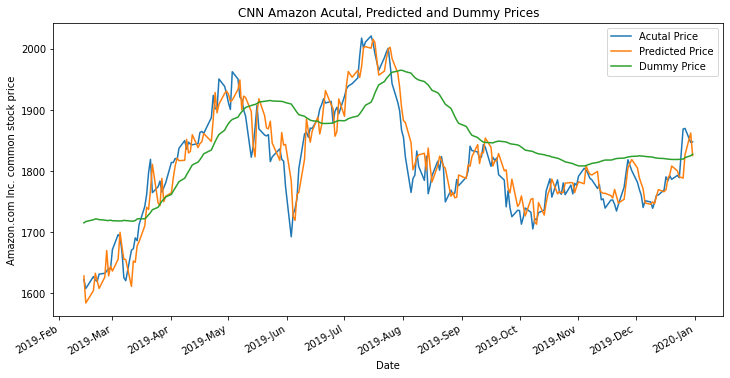

In [16]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

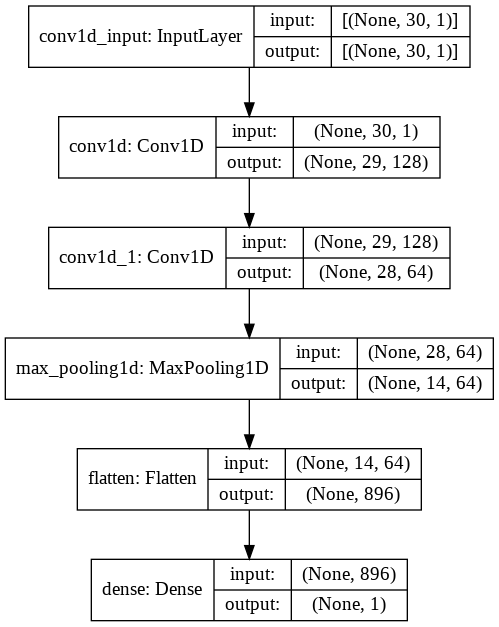

In [17]:
plot_model(model, show_shapes=True, expand_nested=True)

In [18]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.017279400635582847
RMSE:  0.13145113402166925
MAE:  0.11390686042813629
Dummy MSE:  0.03412892153519778
Dummy RMSE:  0.18474014597590255
Dummy MAE:  0.1546333417475681


In [19]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_Amazon/assets
